In [2]:
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Importando os dados para um dataframe
df = pd.read_csv(
    "DadosFalha.csv", 
    na_values=['NA', '?']).drop(["Unnamed: 0","F"], axis=1)
    
lb = preprocessing.LabelBinarizer()
df["Reativa_binarized"] = lb.fit_transform(df['Reativa'])

# Convert to numpy - Classification
features_cols_names = ['Poropressão', 'CoefEmp', 'AlfaBiot', 'AngAtrito','Coesao','Tensao']
x = df[features_cols_names].values
y = df["Reativa_binarized"]

In [3]:
print("Amount of data: ", df.shape[0])

Amount of data:  1000000


## Analysing label distribution

In [4]:
temp_df = df.groupby(["Reativa", "Reativa_binarized"]).size().reset_index(name="count")
temp_df["Percentage"] = round((temp_df["count"]/temp_df["count"].sum())*100, 2)
temp_df

,Reativa,Reativa_binarized,count,Percentage
0,Não Reativa,0,749768,74.98
1,Reativa,1,250232,25.02


## Analyzing features distributions

([<matplotlib.axis.YTick at 0x216c7a6d610>,
 [Text(0, 0, 'P'),
  Text(0, 1, 'k0'),
  Text(0, 2, 'α'),
  Text(0, 3, 'ϕ'),
  Text(0, 4, 'c'),
  Text(0, 5, 'σ')])

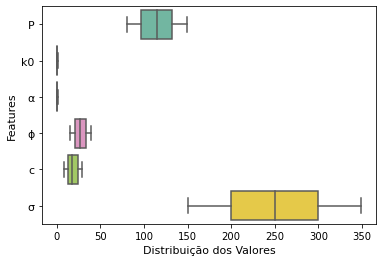

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.xlabel( "Distribuição dos Valores" , size = 11 ) 
plt.ylabel( "Features" , size = 11 ) 
ax = sns.boxplot(data=df[features_cols_names], orient="h",palette="Set2")
ticks, labels = plt.yticks()
plt.yticks(ticks, labels=['P', 'k0','α','ϕ','c','σ'], size=11)


## Some conclusions
    -Looking at the boxplot above, we can see that each feature has its own kind of distribution which seems to be not Normal. Furthermore, the range of values varies over the features.
    -Given that, we should normalize the features before building a neural network model

In [6]:
from sklearn.preprocessing import StandardScaler

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)

x_train_normalized = scaler.transform(x_train)
x_test_normalized = scaler.transform(x_test)

In [7]:
pd.DataFrame(x_train_normalized, columns=features_cols_names).describe()

,Poropressão,CoefEmp,AlfaBiot,AngAtrito,Coesao,Tensao
count,7.500000e+05,7.500000e+05,7.500000e+05,7.500000e+05,7.500000e+05,7.500000e+05
mean,3.706718e-16,4.044494e-14,1.907571e-14,-7.099160e-16,4.246801e-16,1.000500e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.709988e+00,-1.732320e+00,-1.731005e+00,-1.664673e+00,-1.655099e+00,-1.725989e+00
25%,-8.684086e-01,-8.669253e-01,-8.669712e-01,-8.325738e-01,-8.671681e-01,-8.594338e-01
50%,2.267511e-02,2.112568e-03,-2.494574e-04,-4.741119e-04,7.834936e-02,7.121118e-03
75%,8.642541e-01,8.648483e-01,8.662661e-01,8.316256e-01,8.662806e-01,8.563450e-01
max,1.705833e+00,1.732651e+00,1.733299e+00,1.663725e+00,1.654212e+00,1.722900e+00


In [8]:
pd.DataFrame(x_test_normalized,columns=features_cols_names).describe()

,Poropressão,CoefEmp,AlfaBiot,AngAtrito,Coesao,Tensao
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.000398,-0.006091,0.001270,0.002211,-0.001687,-0.002450
std,0.998941,1.000387,1.000857,0.998946,1.000198,1.000180
min,-1.709988,-1.732278,-1.731004,-1.664673,-1.655099,-1.725989
25%,-0.868409,-0.871105,-0.865918,-0.832574,-0.867168,-0.859434
50%,0.022675,-0.011732,0.002585,-0.000474,-0.079237,-0.010210
75%,0.864254,0.861254,0.865297,0.831626,0.866281,0.856345
max,1.705833,1.732650,1.733292,1.663725,1.654212,1.722900


In [9]:
temp_df= pd.DataFrame(y_train).groupby("Reativa_binarized").size().reset_index(name="count")
temp_df["Percentage"] = round((temp_df["count"]/temp_df["count"].sum())*100, 2)
temp_df

,Reativa_binarized,count,Percentage
0,0,562580,75.01
1,1,187420,24.99


In [10]:
y_train.shape

(750000,)

In [11]:
temp_df= pd.DataFrame(y_test).groupby("Reativa_binarized").size().reset_index(name="count")
temp_df["Percentage"] = round((temp_df["count"]/temp_df["count"].sum())*100, 2)
temp_df

,Reativa_binarized,count,Percentage
0,0,187188,74.88
1,1,62812,25.12


In [12]:
y_test.shape

(250000,)

        Poropressão   CoefEmp  AlfaBiot  AngAtrito    Coesao    Tensao
0         -1.165436  1.121599 -0.981268   0.276892 -1.024754 -0.703454
1         -1.511969 -0.512535  0.913286  -1.525990 -0.394409 -0.304839
2         -0.323857 -1.091544 -0.122282  -1.248624  1.654212 -0.807441
3          0.072180 -0.971000 -1.687523   0.970309  0.078349  0.527054
4          1.606824  0.198729  0.648233   1.386359 -0.551996 -0.374163
...             ...       ...       ...        ...       ...       ...
749995     0.963263  0.876697  0.326812   1.663725  0.078349  1.549589
749996    -1.264446 -0.262883  0.284199   0.970309 -0.394409  1.566920
749997     0.666236 -0.858136 -0.275462   0.831626  1.496626 -0.252845
749998     1.408805  1.112035 -1.563925  -1.387307 -0.236823 -0.599467
749999     1.260291  1.701698 -0.437701   1.525042  0.551108  1.116311

[750000 rows x 6 columns]


([<matplotlib.axis.YTick at 0x216c8212160>,
 [Text(0, 0, 'P'),
  Text(0, 1, 'k0'),
  Text(0, 2, 'α'),
  Text(0, 3, 'ϕ'),
  Text(0, 4, 'c'),
  Text(0, 5, 'σ')])

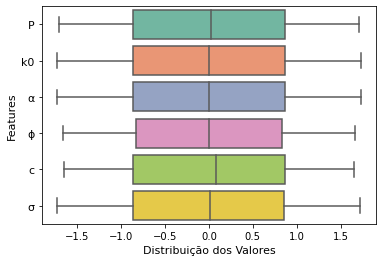

In [13]:
# BoxPlot x_train_normalized
import matplotlib.pyplot as plt
import seaborn as sns
data_norm_x_train=pd.DataFrame(x_train_normalized, columns=features_cols_names)
print(data_norm_x_train)
ax = sns.boxplot(data=data_norm_x_train, orient="h", palette="Set2")
plt.xlabel( "Distribuição dos Valores" , size = 11 ) 
plt.ylabel( "Features" , size = 11 ) 
ticks, labels = plt.yticks()
plt.yticks(ticks, labels=['P', 'k0','α','ϕ','c','σ'], size=11)


        Poropressão   CoefEmp  AlfaBiot  AngAtrito    Coesao    Tensao
0         -0.868409  0.643638  0.765688   1.247675 -1.024754 -0.530143
1         -0.125839  0.375381  0.954194   0.415576 -1.497513  0.180432
2         -1.412960 -1.112378  1.292712  -0.277841  1.181453 -1.656664
3          0.121684  1.350639  0.894562  -1.109940  1.023867  1.722900
4          0.270198  1.191342 -0.676667   1.663725 -0.551996 -1.431360
...             ...       ...       ...        ...       ...       ...
249995     1.210787  0.696053 -0.247270   1.108992  0.866281 -0.634130
249996    -1.214941 -0.013316  0.073892  -0.000474 -0.867168  0.215094
249997     0.022675 -1.356885  1.181391  -1.109940  0.551108  0.232425
249998     0.468217 -0.419524  0.151672   0.554259  1.654212  1.549589
249999     0.517722 -1.509525 -0.904847  -1.664673  0.866281 -1.102069

[250000 rows x 6 columns]


([<matplotlib.axis.YTick at 0x216c82e2ee0>,
 [Text(0, 0, 'P'),
  Text(0, 1, 'k0'),
  Text(0, 2, 'α'),
  Text(0, 3, 'ϕ'),
  Text(0, 4, 'c'),
  Text(0, 5, 'σ')])

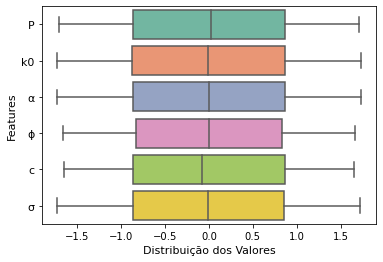

In [14]:
# BoxPlot x_test_normalized
import matplotlib.pyplot as plt
import seaborn as sns
data_norm_x_test=pd.DataFrame(x_test_normalized, columns=features_cols_names)
print(data_norm_x_test)
bx = sns.boxplot(data=data_norm_x_test, orient="h", palette="Set2")
plt.xlabel( "Distribuição dos Valores" , size = 11 ) 
plt.ylabel( "Features" , size = 11 ) 
ticks, labels = plt.yticks()
plt.yticks(ticks, labels=['P', 'k0','α','ϕ','c','σ'], size=11)

## Train a neural network model using keras framework

In [15]:
# Build neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(1, activation='sigmoid')) # Output
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

monitor = EarlyStopping(monitor='val_loss',
                        min_delta=1e-3, patience=5, 
                        verbose=1,
                        mode='auto',
                        restore_best_weights=True,
                        )

history=model.fit(x_train_normalized,
          y_train,
          validation_data=(x_test_normalized,y_test),
          callbacks=[monitor],
          verbose=2,
          epochs=1000,
          )

Epoch 1/1000
23438/23438 - 20s - loss: 0.0389 - acc: 0.9883 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 2/1000
23438/23438 - 19s - loss: 0.0149 - acc: 0.9955 - val_loss: 0.0125 - val_acc: 0.9965
Epoch 3/1000
23438/23438 - 19s - loss: 0.0116 - acc: 0.9963 - val_loss: 0.0119 - val_acc: 0.9951
Epoch 4/1000
23438/23438 - 20s - loss: 0.0099 - acc: 0.9968 - val_loss: 0.0090 - val_acc: 0.9972
Epoch 5/1000
23438/23438 - 20s - loss: 0.0088 - acc: 0.9972 - val_loss: 0.0081 - val_acc: 0.9976
Epoch 6/1000
23438/23438 - 20s - loss: 0.0080 - acc: 0.9974 - val_loss: 0.0080 - val_acc: 0.9972
Epoch 7/1000
23438/23438 - 20s - loss: 0.0075 - acc: 0.9975 - val_loss: 0.0077 - val_acc: 0.9972
Epoch 8/1000
23438/23438 - 20s - loss: 0.0071 - acc: 0.9975 - val_loss: 0.0071 - val_acc: 0.9975
Epoch 9/1000
23438/23438 - 20s - loss: 0.0067 - acc: 0.9977 - val_loss: 0.0074 - val_acc: 0.9970
Epoch 10/1000
23438/23438 - 20s - loss: 0.0064 - acc: 0.9978 - val_loss: 0.0060 - val_acc: 0.9981
Epoch 11/1000
23438/23438 - 2

In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test_normalized, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
1954/1954 [==============================] - 1s 655us/step - loss: 0.0060 - acc: 0.9981
test loss, test acc: [0.0060033961199223995, 0.9981240034103394]


In [17]:
from sklearn.metrics import accuracy_score

pred = model.predict(x_test_normalized)
print(pred)
predict_classes = ((pred > 0.5)+0).ravel()
print(predict_classes)
correct = accuracy_score(y_test,predict_classes)
print(f"Accuracy: {correct}")

[[0.0000000e+00]
 [4.5272388e-31]
 [1.9258860e-11]
 ...
 [1.0000000e+00]
 [3.9722110e-21]
 [1.0000000e+00]]
[0 0 0 ... 1 0 1]
Accuracy: 0.998124


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_classes, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    187188
           1       1.00      1.00      1.00     62812

    accuracy                           1.00    250000
   macro avg       1.00      1.00      1.00    250000
weighted avg       1.00      1.00      1.00    250000



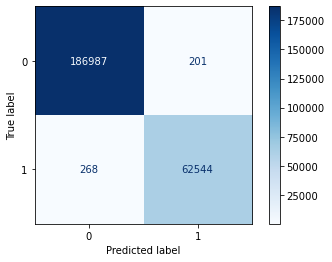

In [19]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_list(), list(predict_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["0", "1"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
confusion_matrix(y_test.to_list(), list(predict_classes))

array([[186987,    201],
       [   268,  62544]], dtype=int64)

                   Poropressão  AlfaBiot   CoefEmp  AngAtrito    Coesao  \
Poropressão           1.000000  0.000522 -0.000604   0.001189 -0.001614   
AlfaBiot              0.000522  1.000000  0.002060   0.000045 -0.000441   
CoefEmp              -0.000604  0.002060  1.000000  -0.000341  0.000059   
AngAtrito             0.001189  0.000045 -0.000341   1.000000 -0.001165   
Coesao               -0.001614 -0.000441  0.000059  -0.001165  1.000000   
Tensao               -0.001416 -0.001500  0.000279   0.001007 -0.000554   
Reativa_binarized    -0.023454 -0.068290 -0.694032  -0.200498 -0.103458   

                     Tensao  Reativa_binarized  
Poropressão       -0.001416          -0.023454  
AlfaBiot          -0.001500          -0.068290  
CoefEmp            0.000279          -0.694032  
AngAtrito          0.001007          -0.200498  
Coesao            -0.000554          -0.103458  
Tensao             1.000000           0.106836  
Reativa_binarized  0.106836           1.000000  


<AxesSubplot:>

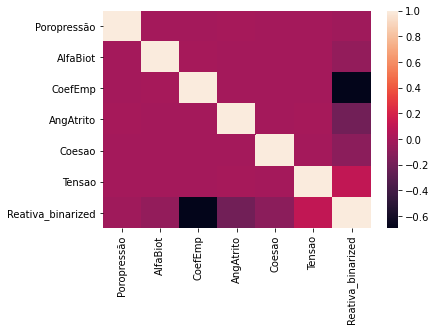

In [21]:
corr=df.corr()
print(corr)
sns.heatmap(corr,
           xticklabels=corr.columns,
           yticklabels=corr.columns)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


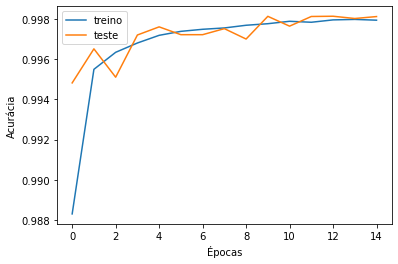

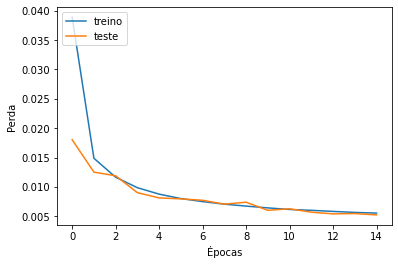

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.title('Modelo Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
#plt.ylim([0, 1])
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Modelo Perda')
plt.ylabel('Perda')
plt.xlabel('Épocas')
#plt.ylim([0, 1])
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

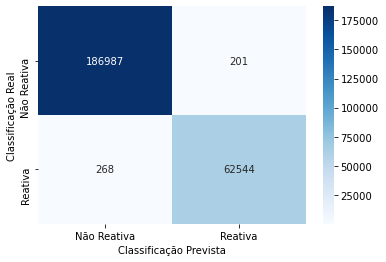

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt    

ax= plt.subplot()

cm = confusion_matrix(y_test.to_list(), list(predict_classes))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Classificação Prevista');ax.set_ylabel('Classificação Real');
#ax.set_title('Matriz de Confusão');
ax.xaxis.set_ticklabels(['Não Reativa', 'Reativa']); ax.yaxis.set_ticklabels([ 'Não Reativa','Reativa']);